In [39]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup # remove HTML tags

# tokenization
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt") # Download necessary datasets for tokenization

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [9]:
# Load csv file into a dataframe
df = pd.read_csv("emails_dataset.csv", encoding="utf-8")

print(df.head())

                                                text label
0            Subject: christmas tree farm pictures\n   ham
1  Subject: vastar resources , inc .\ngary , prod...   ham
2  Subject: calpine daily gas nomination\n- calpi...   ham
3  Subject: re : issue\nfyi - see note below - al...   ham
4  Subject: meter 7268 nov allocation\nfyi .\n- -...   ham


In [11]:
# check no of rows, columns, and data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33715 entries, 0 to 33714
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    33715 non-null  object
 1   label   33715 non-null  object
dtypes: object(2)
memory usage: 526.9+ KB
None


In [13]:
# check for missing values
print(df.isnull().sum())

text     0
label    0
dtype: int64


In [15]:
# check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 3222


In [17]:
# summary statistics for numerical columns
print(df.describe())

# Summary statistics for categorical columns (unique values)
print(df.describe(include="object"))

               text  label
count         33715  33715
unique        30493      2
top     Subject: \n   spam
freq             51  17170
               text  label
count         33715  33715
unique        30493      2
top     Subject: \n   spam
freq             51  17170


label
spam    17170
ham     16545
Name: count, dtype: int64


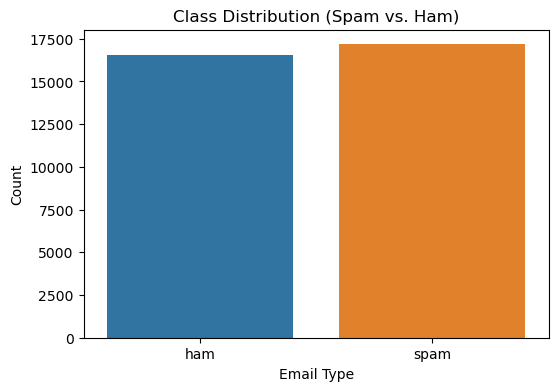

In [19]:
# Check class distribution
print(df["label"].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x=df["label"])
plt.title("Class Distribution (Spam vs. Ham)")
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.show()

In [21]:
# STEP 2 -> REMOVE DUPLICATE ENTRIES
df = df.drop_duplicates().reset_index(drop=True)

print(f"Remaining duplicate rows: {df.duplicated().sum()}")
print(f"New dataset size: {df.shape}")

print(df.isnull().sum())

# check new data structure
print(df.info())

# confirm class distribution
print(df['label'].value_counts())

Remaining duplicate rows: 0
New dataset size: (30493, 2)
text     0
label    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30493 entries, 0 to 30492
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30493 non-null  object
 1   label   30493 non-null  object
dtypes: object(2)
memory usage: 476.6+ KB
None
label
ham     15910
spam    14583
Name: count, dtype: int64


In [23]:
# STEP 3 STANDARDIZE TEXT FORMAT
df['text'] = df['text'].str.lower()

# remoce excess spaces and line breaks
df['text'] = df['text'].apply(lambda x: re.sub(r"\s+", " ", x).strip())

print(df['text'].head(5))

0                subject: christmas tree farm pictures
1    subject: vastar resources , inc . gary , produ...
2    subject: calpine daily gas nomination - calpin...
3    subject: re : issue fyi - see note below - alr...
4    subject: meter 7268 nov allocation fyi . - - -...
Name: text, dtype: object


In [25]:
# STEP 4 -> Remove unnecessary elements
# remove html tags
def remove_html(text):
    # Check if the text contains HTML tags
    if '<' in text and '>' in text:
        return BeautifulSoup(text, "html.parser").get_text()
    else:
        # Return the text as-is if it doesn't contain HTML
        return text

df['text'] = df['text'].apply(remove_html)

# remove URLS
def remove_urls(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    
df['text'] = df['text'].apply(remove_urls)

# remove EMAIL ADDRESSES
def remove_emails(text):
    return re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "", text)

df["text"] = df["text"].apply(remove_emails)

# remove Special characters, numbers and punctuation
def remove_special_chars(text):
    return re.sub(r"[^a-zA-Z\s]", "", text)

df['text'] = df['text'].apply(remove_special_chars)

print(df['text'].head(5))

0                 subject christmas tree farm pictures
1    subject vastar resources  inc  gary  productio...
2    subject calpine daily gas nomination  calpine ...
3    subject re  issue fyi  see note below  already...
4    subject meter  nov allocation fyi             ...
Name: text, dtype: object


In [41]:
# STEP 5 -> TOKENIZATION & STOP WORDS REMOVAL
df['text'] = df['text'].apply(word_tokenize)

# remove stop words
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

df['text'] = df['text'].apply(lambda words: [word for word in words if word not in stop_words])

print(df["text"].head(5))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


0           [subject, christmas, tree, farm, pictures]
1    [subject, vastar, resources, inc, gary, produc...
2    [subject, calpine, daily, gas, nomination, cal...
3    [subject, issue, fyi, see, note, already, done...
4    [subject, meter, nov, allocation, fyi, forward...
Name: text, dtype: object


In [45]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk

nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()

# Function to convert NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun

# Apply lemmatization with POS tagging
def lemmatize_text(text):
    if isinstance(text, list):
        text = ' '.join(text)  # Join list into a string
    
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return " ".join(lemmatized_words)  # into a sentence

df['text'] = df['text'].apply(lemmatize_text)

# Check the results
print(df['text'].head(5))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0                  subject christmas tree farm picture
1    subject vastar resource inc gary production hi...
2    subject calpine daily gas nomination calpine d...
3    subject issue fyi see note already do stella f...
4    subject meter nov allocation fyi forward lauri...
Name: text, dtype: object


In [47]:
# STEP 7 -> FEATURE EXTRACTION (APPLY TF-IDF)

tfidf = TfidfVectorizer(
    ngram_range=(1,2),    # Unigrams + Bigrams  
    max_features=10000,   # Limit vocabulary  
    max_df=0.95,          # Remove words in >95% of docs  
    min_df=5,             # Remove words in <5 docs  
    stop_words='english', # Remove common words  
    sublinear_tf=True     # Normalize word frequency  
)

# convert text to numerical features
X = tfidf.fit_transform(df['text'])

print(X.shape)

(30493, 10000)


In [55]:
# STEP 8 -> Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# check the split
print("Training Set:", X_train.shape, y_train.shape)
print("Testing Set:", X_test.shape, y_test.shape)

Training Set: (24394, 10000) (24394,)
Testing Set: (6099, 10000) (6099,)


In [57]:
# STEP 9 -> FINAL CHECKS
print(df.isnull().sum())

print("Final dataset shape:", df.shape)

print(df['label'].value_counts())

# save cleaned dataset to csv
df.to_csv("clean_email_dataset.csv", index=False)
print("✅ Cleaned dataset saved successfully!")

text     0
label    0
dtype: int64
Final dataset shape: (30493, 2)
label
ham     15910
spam    14583
Name: count, dtype: int64
✅ Cleaned dataset saved successfully!
